In [1]:
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.pyplot as plt
import torch.nn.functional as F
import PIL, urllib
from torchvision.datasets import FashionMNIST
from torchvision import transforms
import numpy as np
import torch
import torch.nn as nn

import warnings
warnings.filterwarnings("ignore", category=UserWarning) 

In [2]:
%%javascript
document.title = "My OEAW SummerSchool App";

<IPython.core.display.Javascript object>

In [3]:
default_url = 'https://upload.wikimedia.org/wikipedia/commons/2/24/Blue_Tshirt.jpg'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
display(widgets.HTML('''
<h1>
My OEAW Summer School App
</h1>
<p style="max-width: 500px;">
This app takes a url to a .jpg or .png image.
Converts it into a grey scale 28x28 image and passes
it through neural network trained on FashionMNIST dataset.
The predicted class is than simply displayed as a text.
Type in an image url and press enter.
</p>
'''))

HTML(value='\n<h1>\nMy OEAW Summer School App\n</h1>\n<p style="max-width: 500px;">\nThis app takes a url to a…

In [5]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        # input layer
        self.linear1 = nn.Linear(784, 1024)
        #hidden layers
        self.linear2 = nn.Linear(1024, 2048)
        self.linear3 = nn.Linear(2048, 1024)
        self.linear4 = nn.Linear(1024, 512)
        #output layer
        self.linear5 = nn.Linear(512, 10)
        
        self.dropout1 = nn.Dropout(p=0.2)  # values changed in exercise 3
        self.dropout2 = nn.Dropout(p=0.1)
        self.dropout3 = nn.Dropout(p=0.1)
        self.dropout4 = nn.Dropout(p=0.1)

        self.bn1 = nn.BatchNorm1d(1024)
        self.bn2 = nn.BatchNorm1d(2048)
        self.bn3 = nn.BatchNorm1d(1024)

    def forward(self, x):
        x = self.linear1(x)
        x = self.dropout1(x)
        x = F.relu(x)
        #x = self.bn1(x)
        
        x = self.linear2(x)
        x = self.dropout2(x)
        x = F.relu(x)
        #x = self.bn2(x)
        
        x = self.linear3(x)
        x = self.dropout3(x)
        x = F.relu(x)
        #x = self.bn3(x)
        
        x = self.linear4(x)
        x = self.dropout4(x)
        x = F.selu(x)
        
        x = self.linear5(x)
        x = F.log_softmax(x, dim=1)
        return x

In [6]:
class ConvNet(nn.Module):
    # CNN architecture (two conv layers followed by three fully connected layers)
    
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64*5*5, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
        self.dropout1 = nn.Dropout(p=0.2)
        self.dropout2 = nn.Dropout2d(0.1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.dropout2(x)
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = self.dropout2(x)
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 64*5*5)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(x, dim=1)
        return x

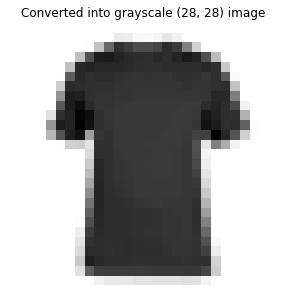

ValueError('Expected tensor to be a tensor image of size (C, H, W). Got tensor.size() = torch.Size([1, 1, 28, 28]).')

In [10]:
@interact(mt=widgets.RadioButtons(
    options=['CNN', 'NN'],
    value='CNN',
    description='Model:',
    disabled=False
))
def f(mt):
    if mt == 'CNN':
        model = ConvNet()
        model_path = 'trained_cnn.pt'
        shape = (28,28)
    else:
        model = NeuralNet()
        model_path = 'trained_model.pt'
        shape=(784,)

    # Load the desired model
    model.load_state_dict(torch.load(model_path, map_location=device));
    model.eval()
    
    @interact(
        url=widgets.Text(
            value=default_url,
            placeholder='Type in an image URL.',
            description='Image URL:',
            disabled=False,
            continuous_update=False))
    def g(url):
        try:
            # Load and transform the image
            img_arr = PIL.Image.open(
                urllib.request.urlopen(url)).convert('L').resize((28,28))

            # Plot the transformed image
            plt.figure(figsize=(5,5))
            plt.imshow(img_arr, cmap='gray', aspect='equal')
            plt.title(f'Converted into grayscale {img_arr._size} image')
            plt.axis('off')
            plt.show()   

            # Convert the image to tensor
            data = torch.tensor(np.array(img_arr), dtype=torch.float32).view(1, 1, *shape)
            data = transforms.Normalize((0.1307,), (0.3081,))(data)
            
            # Pass it through the model and display the result
            with torch.no_grad():
                display(FashionMNIST.classes[model(data).argmax().item()])
            
        except Exception as e:
            display(e)
